Single qubit errors validated against Egan paper
========================================

This is a simulation of single qubit errors in an ion trap quantum computer to compare the Qiskit noise model with experiments by Egan [1].  The noise model will be used on a simulation of the Steane code.

This simulation uses the randomised benchmark function from Qiskit to simulate Egan's characterization of single qubit errors.  A circuit is constructed with N-1 sequential random Clifford gates and a final Clifford gate that inverts the others.  In the circuit diagram below the Clifford gates are separated by a barrier.

With no noise the qubit will always finish in the starting |0> ground state.  A simulation was run and the ground state population is shown plotted against the number of Clifford gates.  For comparison a calculation of the expected ground state population using a error per Clifford gate of 3.4(8)×10−4 as quoted by Egan is shown.

There are two caveats to this simulation.

Firstly the Clifford gate composition provided by Qiskit decomposes each Clifford gate into native Qiskit gates including the Pauli gates, X, Y, Z, the Hadamard, the S or Phase gate and it's inverse SDG.  In Quiskit aach Clifford gate is a composition of up to four gates, for example, XSHS.  There are an average of around 2.4 of the native gates for each Clifford gate. Egan used a different native gate set with gates like X/2 and had an average of only 1.875 gates for each Clifford gate.  Since the Qiskit simulation has more gates there are more chances for error and a lower ground state population is expected.   

Secondly we use a depolarising error with a parameter which represents the chance that a X, Y, Z and I error occurs.  Since a Z and I error won't be detectable we have doubled Egan's stated error of 1.8(3)×10−4 per native Pauli gate to use as the depolarising error parameter.

Egan shows two results, one for the 1 ion chain, and one for the less accurate but more realistic 15 ion chain.

Our simulation shows results broadly aligned with Egan.  The single gate error is not a key parameter.  It is much less that the two gate error and is often neglected in simulations by other workers.  On this basis our error model is reasonable as our results are within 0.1% of Egan's 15 ion chain with a gate depth of 20 .

[1] Egan L, Debroy DM, Noel C, Risinger A, Zhu D, Biswas D, et al. Fault-Tolerant Operation of a Quantum Error-Correction Code. arXiv Available from: http://arxiv.org/abs/2009.11482

This is part of an MSc project on the Steane code.  Please see https://goldsmdn.github.io/ for full details.

Import the necessary function modules.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.quantum_info import Clifford

# Import the randomized benchmarking Function
import qiskit.ignis.verification.randomized_benchmarking as rb

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

import random
import matplotlib.pyplot as plt
import numpy as np

Define constants so the process flow can be controlled from one place:

In [2]:
SHOTS = 10000                            #Number of shots to run 
ITERATIONS = 25                          #Number of iterations for each simulation
MEASURE_NOISE = 0.0046                   #Measurement noise
SINGLE_GATE_DEPOLARISING = 0.000366      #Parameter for depolarising channel
SINGLE_CLIFFORD_GATE_NOISE = 0.000348    #Used to calculate theory 
NOISE = True                             #Test with noise?

GATE_DEPTH_LIST = [1, 3, 7, 11, 15, 19]  #Number of Clifford gate to be simulated
                                         # one more reversal gate is automaticaly added

SIMULATOR = Aer.get_backend('qasm_simulator')

Set up circuits in a list.

In [3]:
# Generate randomised benchmark circuit 
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = GATE_DEPTH_LIST
# Number of seeds (random sequences)
rb_opts['nseeds'] = ITERATIONS
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

Draw an example of random circuit for eight Clifford gates.

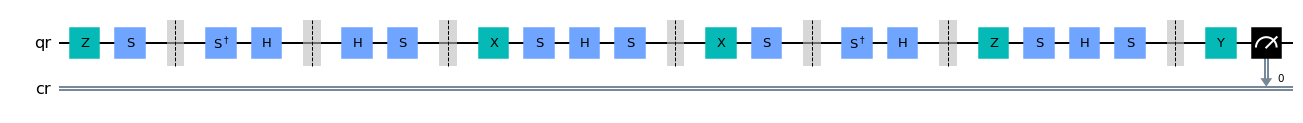

In [4]:
rb_circs[0][2].draw(output='mpl', filename = 'Single_Clifford_gates_circuit.jpg', fold=60)

In [5]:
def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ['x', 'y', 'z', 'h', 's', 'sdg'])  # single qubit gate errors

    return noise_model

In [6]:
noise_model = get_noise(MEASURE_NOISE,SINGLE_GATE_DEPOLARISING)

In [7]:
# initialise lists for graphs
simulation_probability = []
theoretical_probability = []
egan_one_ion_noise = []
egan_fifteen_ion_noise = []
mean_probability = []
number_of_gates_scatter = []
number_of_gates_plot = []

loop_number = 0
for gate_depth in GATE_DEPTH_LIST:
    accumulator = 0
    for iteration in range(ITERATIONS):
        if NOISE:
            result = execute(rb_circs[iteration][loop_number], SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
        else:
            result = execute(rb_circs[iteration][loop_number], SIMULATOR, shots=SHOTS).result()     
        counts = result.get_counts(rb_circs[iteration][loop_number])
        number_of_gates_scatter.append(gate_depth + 1)
        # need to add one gate to allow for the reversal
        probability = counts.get('0') / SHOTS
        simulation_probability.append(probability)
        accumulator = accumulator + probability
    
    mean = accumulator / ITERATIONS
    true_gate_depth = (gate_depth + 1) 
    gate_noise = ((1 - SINGLE_CLIFFORD_GATE_NOISE) ** true_gate_depth) 
    theory = gate_noise * (1 - MEASURE_NOISE)  
    egan_one_ion = 0.99388 - true_gate_depth * 0.000177
    egan_fifteen_ion = 0.9951 - true_gate_depth * 0.000348
    theoretical_probability.append(theory)
    egan_one_ion_noise.append(egan_one_ion)
    egan_fifteen_ion_noise.append(egan_fifteen_ion)
    number_of_gates_plot.append(true_gate_depth)     
    print(f'For {true_gate_depth} gates mean simulated ground state population probability is {mean:.4f} and calculated probability is {theory:.4f}')
    print(f'   The best fit line for Egan 1 ion chain is {egan_one_ion:.4f} and for Egan 15 ion chain is {egan_fifteen_ion:.4f}')
    mean_probability.append(mean)
    loop_number = loop_number + 1

For 2 gates mean simulated ground state population probability is 0.9944 and calculated probability is 0.9947
   The best fit line for Egan 1 ion chain is 0.9935 and for Egan 15 ion chain is 0.9944
For 4 gates mean simulated ground state population probability is 0.9937 and calculated probability is 0.9940
   The best fit line for Egan 1 ion chain is 0.9932 and for Egan 15 ion chain is 0.9937
For 8 gates mean simulated ground state population probability is 0.9921 and calculated probability is 0.9926
   The best fit line for Egan 1 ion chain is 0.9925 and for Egan 15 ion chain is 0.9923
For 12 gates mean simulated ground state population probability is 0.9905 and calculated probability is 0.9913
   The best fit line for Egan 1 ion chain is 0.9918 and for Egan 15 ion chain is 0.9909
For 16 gates mean simulated ground state population probability is 0.9884 and calculated probability is 0.9899
   The best fit line for Egan 1 ion chain is 0.9910 and for Egan 15 ion chain is 0.9895
For 20 g

Plot graph:

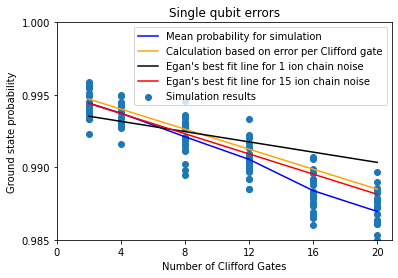

In [8]:
#graph constants
YMIN = 0.985
YMAX = 1.000
YTICK = 0.005

#graph
title_text = "Ground state probabilty against number of Clifford Gates"
plt.scatter(number_of_gates_scatter, simulation_probability, label = "Simulation results" )
plt.plot(number_of_gates_plot, mean_probability, label = "Mean probability for simulation" , color="blue")
plt.plot(number_of_gates_plot, theoretical_probability, label = "Calculation based on error per Clifford gate" , color="orange")
plt.plot(number_of_gates_plot, egan_one_ion_noise, label = "Egan's best fit line for 1 ion chain noise" , color="black")
plt.plot(number_of_gates_plot, egan_fifteen_ion_noise, label = "Egan's best fit line for 15 ion chain noise" , color="red")
plt.title('Single qubit errors')
plt.xlabel('Number of Clifford Gates')
plt.ylabel('Ground state probability')  
plt.legend()
plt.ylim(YMIN, YMAX)
plt.xticks(np.arange(0, 21, 4))
plt.yticks(np.arange(YMIN, YMAX, YTICK))
fname = "Single_Clifford_gate_errors_graph.png"
plt.savefig(fname)

In the graph above the offset corresponds to the state preparation and measurement (SPAM) error of 0.0046 reported by Egan.

The slope gives the error per Clifford gate.  Since the error is small the graph is approximated linear.

For comparise actual Egan's results are shown below.

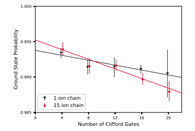